In [1]:
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')
# Basic import
## plot within the notebook
%matplotlib inline
# - Astrobject Modules
import numpy      as np

In [2]:
import matplotlib.pyplot as mpl

In [3]:
from scipy import stats

In [4]:
from pyflat import pyflat

In [5]:
import astrobject

In [6]:
from pyflat.pyflat import flatobjects, io

In [7]:
from astropy import units

In [8]:
from astrobject.utils import mpladdon

***
# Get The Data

In [9]:
from glob import glob
filenames = glob("/Users/mrigault/Desktop/these/code_source/Data/PTF/ptf_starflat/catalogues/*")

Convert the data into SepObjects

In [10]:
reload(flatobjects)

<module 'pyflat.pyflat.flatobjects' from '/Users/mrigault/Libraries/pyflat/pyflat/flatobjects.pyc'>

In [11]:
filenames_12 = [f for f in filenames if "201610012" in f]
filenames_13 = [f for f in filenames if "201610013" in f]
filenames_22 = [f for f in filenames if "201610022" in f]
filenames_23 = [f for f in filenames if "201610023" in f]

In [12]:
time smap = flatobjects.get_flatfielder(filenames_12+filenames_13, wcs_extension=2)

Flat fielder loading
CPU times: user 20.2 s, sys: 407 ms, total: 20.6 s
Wall time: 24.9 s


***
# Download the Catalogue

In [13]:
smap.download_catalogue("sdss", column_filters={"gmag":"15..19"}, force_it=True)

***
# Access the Data

In [14]:
smap.catalogue.define_around(20*units.arcsec)

In [15]:
catindex = smap.get_catindexes(0.3, stars_only=True, isolated_only=True)

In [16]:
#smap.show(catindexes=catindex, ms=6)

***
#  Cleaning

Some Data are bad. Let's first remove the one that do not have enough stars

In [17]:
mag = np.asarray(smap.getcat("mag_auto", catindex))

In [18]:
[smap.remove(id_) for id_ in np.asarray(smap.list_id)[np.sum(1-np.isnan(mag.T), axis=0)<100]]

[None, None, None]

Remove the mag residual std greater than 0.15 mag on average

In [25]:
[smap.remove(id_) for id_ in np.asarray(smap.list_id)[np.nanstd(delta_mag.T,axis=0)>0.15]]

[None, None, None, None, None]

In [ ]:
#[smap.remove(id_) for id_ in np.asarray(smap.list_id)[np.nanstd(delta_mag.T,axis=0)>0.15]]

Check the magnitudes. 

Note that you need to reload mag since you removed some images

In [26]:
catindex  = smap.get_catindexes(0.3, stars_only=True, isolated_only=True)

delta_mag = np.asarray(smap.getcat_residual("mag_auto", catindex, clipping=True))
mjd       = np.asarray(smap.getcat_residual("mjd", catindex))
airmass   = np.asarray(smap.getcat_residual("airmass", catindex))

In [27]:
from pyflat.pyflat import analysis
reload(analysis)

<module 'pyflat.pyflat.analysis' from '/Users/mrigault/Libraries/pyflat/pyflat/analysis.pyc'>

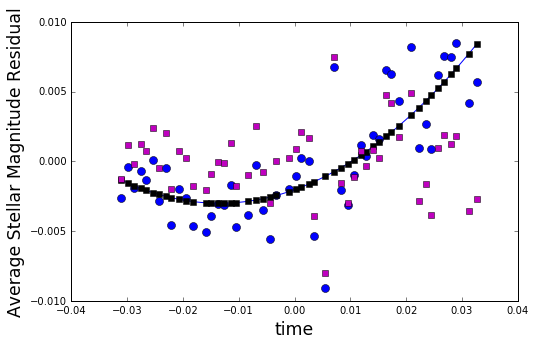

In [39]:
corr_mag = analysis.get_correction(np.nanmean(mjd.T, axis=0), np.nanmedian(delta_mag.T,axis=0), show=True)
mpl.gca().set_xlabel("time", fontsize="xx-large")
mpl.gca().set_ylabel("Average Stellar Magnitude Residual", fontsize="xx-large")
mpl.plot(np.nanmean(mjd.T, axis=0), corr_mag,"ks")

delta_mag_corr = np.asarray(delta_mag.T - corr_mag).T
mpl.plot(np.nanmean(mjd.T, axis=0), np.nanmedian(delta_mag_corr.T,axis=0),"ms")


and |delta_mag_corr|>0.005

In [40]:
[smap.remove(id_) for id_ in np.asarray(smap.list_id)[np.abs(np.nanmedian(delta_mag_corr.T,axis=0))>0.005]]

[None, None]

### Ok You are clean

In [115]:
catindex  = smap.get_catindexes(0.3, stars_only=True, isolated_only=True)
mag_g = smap.catalogue.get("gmag", catindex)
mag_i = smap.catalogue.get("imag", catindex)
catindex_red = catindex[mag_g-mag_i>1.5]
catindex_blue = catindex[mag_g-mag_i<=1.5]

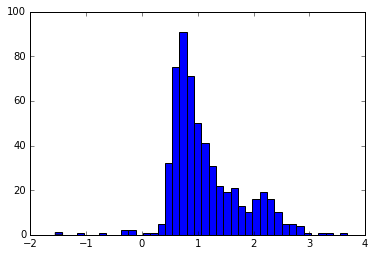

In [117]:
_ = mpl.hist(mag_g-mag_i, bins=40)

In [118]:
delta_mag = np.asarray(smap.getcat_residual("mag_auto", catindex, clipping=True))
mjd       = np.asarray(smap.getcat_residual("mjd", catindex))
airmass   = np.asarray(smap.getcat_residual("airmass", catindex))

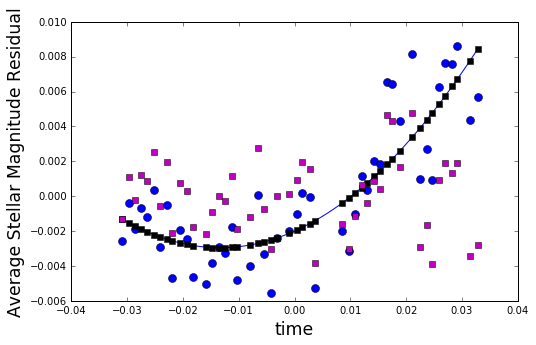

In [119]:
corr_mag = analysis.get_correction(np.nanmean(mjd.T, axis=0), np.nanmedian(delta_mag.T,axis=0), show=True)
mpl.gca().set_xlabel("time", fontsize="xx-large")
mpl.gca().set_ylabel("Average Stellar Magnitude Residual", fontsize="xx-large")
mpl.plot(np.nanmean(mjd.T, axis=0), corr_mag,"ks")

delta_mag_corr = np.asarray(delta_mag.T - corr_mag).T
mpl.plot(np.nanmean(mjd.T, axis=0), np.nanmedian(delta_mag_corr.T,axis=0),"ms")

*** 
# Fit Evolution with time

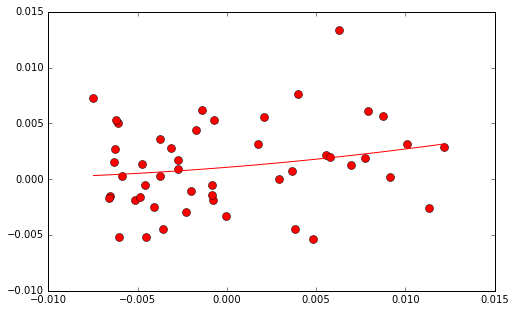

In [43]:
nodept_mag2 = analysis.get_correction(np.nanmean(airmass.T, axis=0), np.nanmean(delta_mag_corr.T,axis=0), show=True, color="r")

## Typical number of star used per image

(array([  1.,   1.,   0.,   1.,   1.,   2.,   5.,   2.,   7.,  28.]),
 array([ 230. ,  258.4,  286.8,  315.2,  343.6,  372. ,  400.4,  428.8,
         457.2,  485.6,  514. ]),
 <a list of 1 Patch objects>)

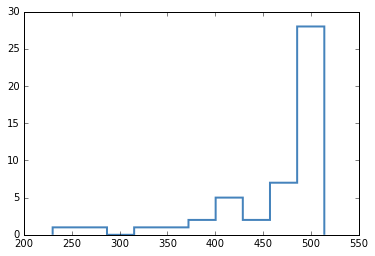

In [47]:
mpl.hist(np.sum(1-np.isnan(airmass.T), axis=0),
         histtype="step", fc=mpl.cm.Blues(0.3,0.3), ec=mpl.cm.Blues(0.8,0.8),
        lw=2)

*** 
# Let's define the Grid

get all the positions

In [48]:
from pyflat.pyflat import grid

In [49]:
from pyflat.pyflat import utils

In [50]:
reload(grid)

<module 'pyflat.pyflat.grid' from '/Users/mrigault/Libraries/pyflat/pyflat/grid.pyc'>

In [51]:
reload(utils)

<module 'pyflat.pyflat.utils' from '/Users/mrigault/Libraries/pyflat/pyflat/utils.pyc'>

In [52]:
#catindex = smap.get_catindexes(0.3, stars_only=True, isolated_only=True)
x        = np.asarray(smap.getcat("x", catindex))
y        = np.asarray(smap.getcat("y", catindex))

In [53]:
xcont, ycont = np.concatenate(x),np.concatenate(y)
flagnan = np.isnan(xcont) * np.isnan(ycont)
xused, yused = xcont[~flagnan], ycont[~flagnan]

In [54]:
xy = np.vstack([xused, yused]).T

In [55]:
from sklearn import cluster
kmean = cluster.KMeans(n_clusters=200, init='k-means++', n_init=10)
kmean_tmp = kmean.fit(xy)

In [56]:
from shapely import geometry
from pyflat.pyflat import grid
edges = geometry.polygon.Polygon([[0,0],[2048,0],[2048,4096],[0,4096]])
vgrid = grid.get_voronoy_grid(kmean.cluster_centers_.T[0],kmean.cluster_centers_.T[1], edges, npergrid=None)

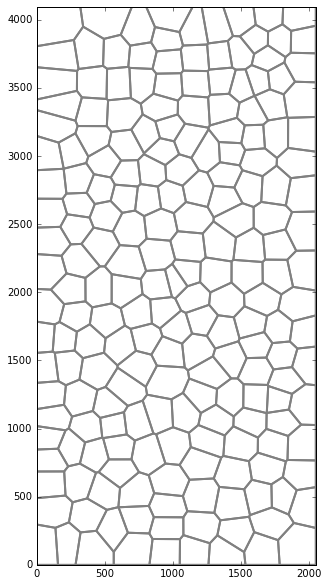

In [57]:
vgrid.show()

In [58]:
reload(grid)

<module 'pyflat.pyflat.grid' from '/Users/mrigault/Libraries/pyflat/pyflat/grid.py'>

In [100]:
rgrid = grid.get_square_grid([0,0,2048,4096], [20,40])

***
# Grid defined. Let's measure responses

In [101]:
from shapely import vectorized

In [120]:
def get_projected_value(grid_, x_,y_, value_):
    return { i:value_[vectorized.contains(p_, x_,y_)] for i,p_ in enumerate(grid_)}

In [102]:
dataout_r = 


In [103]:
nmin = 5
colors   = np.asarray([np.nanmean(dataout[i]) if len(dataout[i])>nmin else np.nan for i,p_ in enumerate(rgrid.grid)])
colorsstd= np.asarray([np.nanstd(dataout[i]) if len(dataout[i])>nmin else np.nan for i,p_ in enumerate(rgrid.grid)])
colors50 = np.asarray([np.nanmedian(dataout[i]) if len(dataout[i])>nmin else np.nan for i,p_ in enumerate(rgrid.grid)])
colors82 = np.asarray([np.percentile(dataout[i], 82) if len(dataout[i])>nmin else np.nan for i,p_ in enumerate(rgrid.grid)])
colors18 = np.asarray([np.percentile(dataout[i], 18) if len(dataout[i])>nmin else np.nan for i,p_ in enumerate(rgrid.grid)])
size = np.asarray([len(dataout[i]) for i,p_ in enumerate(rgrid.grid)])

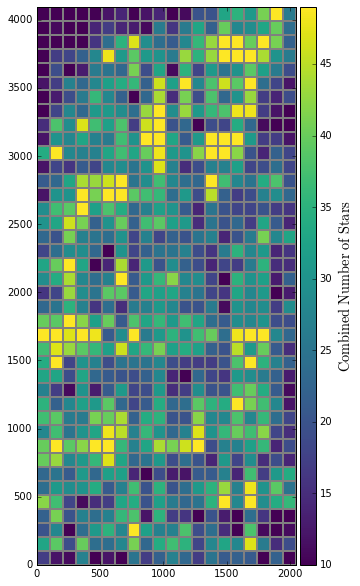

In [104]:
rgrid.show(cval=size,cmap=mpl.cm.viridis, clabel=r"$\mathrm{Combined\ Number\ of\ Stars}$")

In [109]:
reload(utils)

<module 'pyflat.pyflat.utils' from '/Users/mrigault/Libraries/pyflat/pyflat/utils.py'>

Axes(0.402,0.1;0.018x0.8)
Axes(0.912,0.1;0.018x0.8)


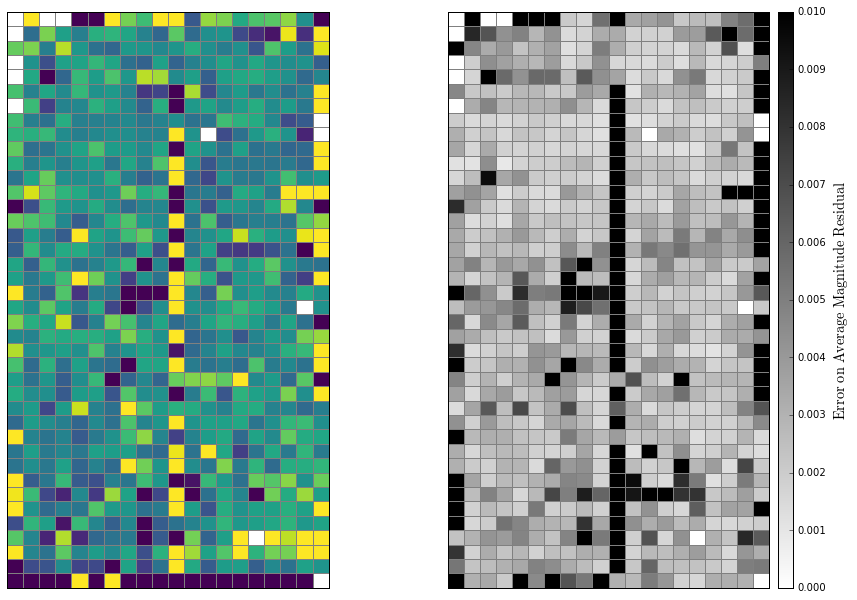

In [111]:
fig = mpl.figure(figsize=[12,10])
ax = fig.add_axes([0.02,0.1,0.4,0.8])
axstd = fig.add_axes([0.53,0.1,0.4,0.8])

rgrid.show(ax=ax,cval=colors,cmap=mpl.cm.viridis,  show=False,
           clabel=r"$\mathrm{Average\ Magnitude\ Residual}$",
          lw=1, vmax=0.01, vmin=-0.01)

rgrid.show(ax=axstd,cval=colorsstd/ np.sqrt(size),cmap=mpl.cm.binary,
           clabel=r"$\mathrm{Error\ on\ Average\ Magnitude\ Residual}$",
          lw=1, vmin=0.0, vmax=0.01)
_=[ax_.set_xticks([]) for ax_ in [ax,axstd]]
_=[ax_.set_yticks([]) for ax_ in [ax,axstd]]

ERROR: AttributeError: 'Axes' object has no attribute 'copy' [IPython.core.interactiveshell]
ERROR:astropy:AttributeError: 'Axes' object has no attribute 'copy'


AttributeError: 'Axes' object has no attribute 'copy'

In [122]:
pmap = smap.photomaps["1"]

In [125]:
mag = pmap.getcat("mag_auto", catindex)
magcat = pmap.catalogue.get("rmag", catindex)

In [128]:
flag_red = np.asarray([c in catindex_red for c in catindex])

(28, 28.5)

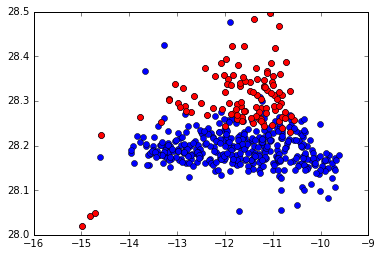

In [129]:
mpl.plot(mag,magcat-mag, "bo")
mpl.plot(mag[flag_red],magcat[flag_red]-mag[flag_red], "ro")
mpl.ylim(28,28.5)

(28, 28.5)

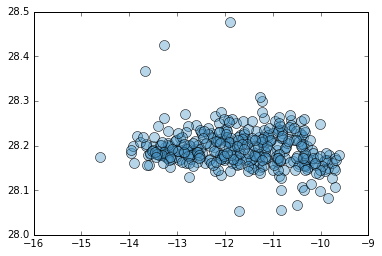

In [131]:

mpl.plot(mag[~flag_red],magcat[~flag_red]-mag[~flag_red], ms=10, mfc=mpl.cm.Blues(0.6,0.4), mec="k",
        marker="o", ls="None")
mpl.ylim(28,28.5)

In [133]:
magres_blue = magcat[~flag_red]-mag[~flag_red]

In [136]:
np.nanstd(magres_blue[magres_blue==magres_blue])

0.16700920397961058

In [1]:
from pyflat.pyflat import analysis

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are Working with Matplotlib in a virtual enviroment see 'Working with Matplotlib in Virtual environments' in the Matplotlib FAQ